In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import pandas as pd
from shapely.geometry import box

## data loading and resampling

 ### where it says all var, SM has actually been used

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable1 = 'wind_u_850hPa'
variable2 = 'wind_v_850hPa'
experiment1 = 'drysoil_d0198_RAL3P2_' #SM 
u_wind = xr.open_dataset(f'{datapath}/{variable1}/{experiment1}{variable1}.nc')['x_wind']
v_wind = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')['y_wind']

experiment2 = 'control_d0198_RAL3P2_' #Control
u_wind_control = xr.open_dataset(f'{datapath}/{variable1}/{experiment2}{variable1}.nc')['x_wind']
v_wind_control = xr.open_dataset(f'{datapath}/{variable2}/{experiment2}{variable2}.nc')['y_wind']

In [3]:
#shift to AEST 
u_wind = u_wind.assign_coords(time=u_wind.time + pd.Timedelta(hours=10))
v_wind = v_wind.assign_coords(time=v_wind.time + pd.Timedelta(hours=10))

u_wind_control = u_wind_control.assign_coords(time=u_wind_control.time + pd.Timedelta(hours=10))
v_wind_control = v_wind_control.assign_coords(time=v_wind_control.time + pd.Timedelta(hours=10))


In [4]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')

In [5]:
#clip fires to domain
lon_min = float(u_wind.longitude.min())
lon_max = float(u_wind.longitude.max())
lat_min = float(u_wind.latitude.min())
lat_max = float(u_wind.latitude.max())

wind_extent = box(lon_min, lat_min, lon_max, lat_max)

fires_clipped = fires.clip(wind_extent)

In [6]:
u_wind_land = u_wind
v_wind_land = v_wind
u_wind_land_control = u_wind_control
v_wind_land_control = v_wind_control

In [7]:
speed_allvar = (u_wind_land**2 + v_wind_land**2)**0.5
speed_allvar = speed_allvar.rename("wind_speed")
speed_control = (u_wind_land_control**2 + v_wind_land_control**2)**0.5
speed_control = speed_control.rename("wind_speed")

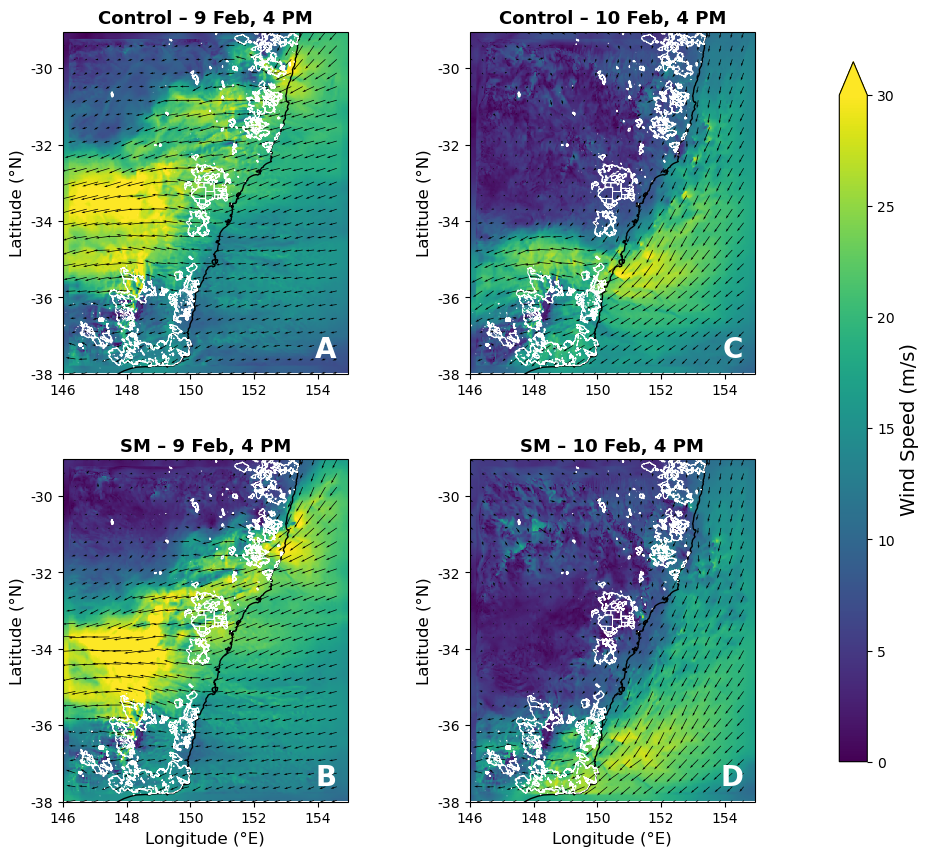

In [8]:
times = [
    np.datetime64("2020-02-09T16:00"),
    np.datetime64("2020-02-10T16:00"),
]
experiments = {
    "Control": (u_wind_land_control, v_wind_land_control, speed_control),
    "SM": (u_wind_land, v_wind_land, speed_allvar)
}

proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(14, 10),
    subplot_kw={"projection": proj}, 
)
fig.subplots_adjust(wspace=-0.4, hspace=0.25)

vmin, vmax = 0, 30
skip = 18  #quiver density

#---loop through experiments (rows) and times (cols)---
for i, (exp_name, (u_da, v_da, spd_da)) in enumerate(experiments.items()):
    for j, t in enumerate(times):
        ax = axes[i, j]

        #select time
        u_plot = u_da.sel(time=t, method="nearest")
        v_plot = v_da.sel(time=t, method="nearest")
        speed_plot = spd_da.sel(time=t, method="nearest")

        #plot speed
        im = ax.pcolormesh(
            speed_plot.longitude, speed_plot.latitude, speed_plot,
            vmin=vmin, vmax=vmax, cmap="viridis",
            transform=ccrs.PlateCarree()
        )

        #quiver
        ax.quiver(
            speed_plot.longitude[::skip],
            speed_plot.latitude[::skip],
            u_plot.values[::skip, ::skip],
            v_plot.values[::skip, ::skip],
            transform=ccrs.PlateCarree(),
            color="black",
            scale=500
        )

        #fires
        gpd.GeoSeries(fires_clipped.boundary).plot(
            ax=ax, edgecolor="white", linewidth=0.7,
            facecolor="none", transform=ccrs.PlateCarree()
        )

        ax.coastlines(color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)

        date_label = pd.Timestamp(t)
        day = date_label.day
        month = date_label.strftime('%b')  #'Feb'
        time_label = date_label.strftime('%-I %p')  #'4 PM'
        
        ax.set_title(f"{exp_name} – {day} {month}, {time_label}", fontsize=13, fontweight='bold')
        ax.set_xlabel("Longitude (°E)", fontsize=12)
        ax.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)])
        ax.set_ylabel("Latitude (°N)", fontsize=12)
        ax.set_yticks(np.arange(-38, -28, 2), crs=proj)
        ax.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)])
        ax.tick_params(labelsize=10)


for ax in axes[0, :]:
    ax.set_xlabel("")
    # ax.set_xticklabels([])
    
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="vertical", extend="max")
cbar.set_label("Wind Speed (m/s)", fontsize = 14)

labels = ["A", "C", "B", "D"]

for ax, label in zip(axes.flat, labels):
    ax.text(
        0.96, 0.03,  
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight='bold',
        va='bottom',
        ha='right', 
        color = 'white'
    )

# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/850winds_raw_feb.png', bbox_inches = 'tight', dpi=350)
plt.show()
